In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.4f' % x)

PROJECT_DIR = os.path.join(os.path.dirname('lstm_model.ipynb'), os.pardir) + '/..'

# Import Data

In [2]:
# Reading the up-sampled dataset
up_train = pd.read_csv(f'{PROJECT_DIR}/data/processed/augmented_train.csv', usecols=['Description', 'Accident Level'])
test = pd.read_csv(f'{PROJECT_DIR}/data/processed/augmented_test.csv', usecols=['Description', 'Accident Level'])
up_train.head()

,Description,Accident Level
0,By manually moving a steel cabinet for disposa...,3
1,Once the mooring of the faneles in the detonat...,1
2,When performing cleaning activity of the area ...,3
3,The technician was doing the magnetometric sur...,1
4,The operator cleaned with spatula spear throug...,1


# Process Text

In [3]:
# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords

# to remove common stop words
from nltk.corpus import stopwords

# to generate a wordcloud
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suhai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def process_description(df):
    # To lowercase
    df['description_stripped'] = df['Description'].str.strip()

    # Removing stop-words
    df['description_stopwords_removed'] = df['description_stripped'].progress_apply(
        lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')])).str.strip()
    
    return df

In [5]:
up_train = process_description(up_train)
test = process_description(test)
up_train.head()

  0%|          | 0/1155 [00:00<?, ?it/s]

100%|██████████| 105/105 [00:05<00:00, 20.30it/s]


,Description,Accident Level,description_stripped,description_stopwords_removed
0,By manually moving a steel cabinet for disposa...,3,By manually moving a steel cabinet for disposa...,By manually moving steel cabinet disposal help...
1,Once the mooring of the faneles in the detonat...,1,Once the mooring of the faneles in the detonat...,Once mooring faneles detonating cord completed...
2,When performing cleaning activity of the area ...,3,When performing cleaning activity of the area ...,When performing cleaning activity area near 04...
3,The technician was doing the magnetometric sur...,1,The technician was doing the magnetometric sur...,The technician magnetometric survey stepped th...
4,The operator cleaned with spatula spear throug...,1,The operator cleaned with spatula spear throug...,The operator cleaned spatula spear one windows...


## Word Cloud

In [6]:
def display_wordcloud(series):
    # Generating wordcloud
    word_cloud = WordCloud(width = 1000, height = 600, background_color ='white', min_font_size = 10)
    word_cloud.generate(' '.join(list(series.apply(lambda x: x.lower()))))

    # plot the WordCloud image                       
    plt.figure(figsize=(6, 6), facecolor = None)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show();

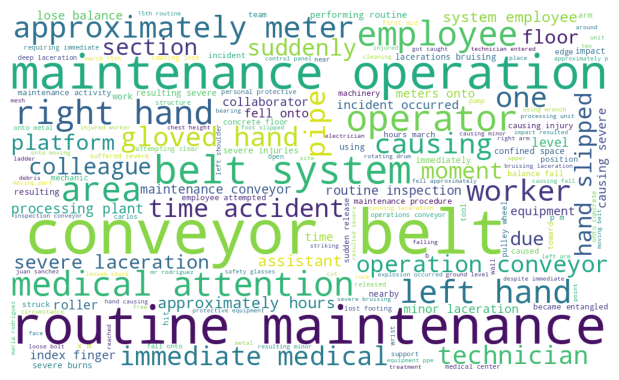

In [7]:
display_wordcloud(up_train['description_stopwords_removed'])

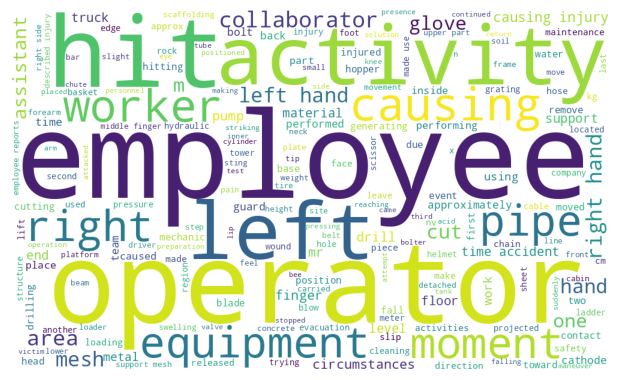

In [8]:
display_wordcloud(test['description_stopwords_removed'])

# Tokenization

In [9]:
# Splitting features and targets
x_train = up_train['description_stripped']
x_train_swr = up_train['description_stopwords_removed']
y_train = up_train['Accident Level']

x_test = test['description_stripped']
x_test_swr = test['description_stopwords_removed']
y_test = test['Accident Level']

In [10]:
from tensorflow.keras.layers import TextVectorization

tokenizer = TextVectorization(
    max_tokens=5000,
    output_mode='int',
    standardize='lower_and_strip_punctuation',
)
tokenizer.adapt(x_train)

tokenizer_swr = TextVectorization(
    max_tokens=5000,
    output_mode='int',
    standardize='lower_and_strip_punctuation',
)
tokenizer_swr.adapt(x_train_swr)

In [11]:
print('Vocabulary size:')
print('Descriptions:', tokenizer.vocabulary_size())
print('Stop-words removed descriptions:', tokenizer_swr.vocabulary_size())

Vocabulary size:
Descriptions: 4839
Stop-words removed descriptions: 4788


## Alternate Method

In [12]:
# from tensorflow.keras.preprocessing.text import Tokenizer

# tokenizer = Tokenizer(num_words=5000, lower=True)
# tokenizer.fit_on_texts(x_train)
# x_train = tokenizer.texts_to_sequences(x_train)
# x_test = tokenizer.texts_to_sequences(x_test)

# tokenizer_swr = Tokenizer(num_words=5000, lower=True)
# tokenizer_swr.fit_on_texts(x_train_swr)
# x_train_swr = tokenizer_swr.texts_to_sequences(x_train_swr)
# x_test_swr = tokenizer_swr.texts_to_sequences(x_test_swr)

In [13]:
# print('Vocabulary size:')
# print('Descriptions:', len(tokenizer.word_index))
# print('Stop-words removed descriptions:', len(tokenizer_swr.word_index))

In [14]:
# print('Max of Sequence Length')
# print('Descriptions:', max([len(seq) for seq in x_train]))
# print('Stop-words removed descriptions:', max([len(seq) for seq in x_train_swr]))

In [15]:
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# x_train = pad_sequences(x_train, padding='post')
# x_test = pad_sequences(x_test, padding='post')

# x_train_swr = pad_sequences(x_train_swr, padding='post')
# x_test_swr = pad_sequences(x_test_swr, padding='post')

# Label OHE

In [16]:
# Label encoding to ensure the labels start from 0
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [17]:
# One-hot encoded vectors
from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

y_train_ohe

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

# Model LSTM

In [85]:
from tensorflow import string
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, GlobalMaxPool1D, Dropout

In [19]:
# Loading pre-trained GloVe word embeddings
EMBEDDING_SIZE = 200
embeddings_dictionary = dict()

glove_file = open(f'{PROJECT_DIR}/models/glove.6B.200d/glove.6B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

In [20]:
# Embedding matrix for Descriptions
embedding_matrix = np.zeros((tokenizer.vocabulary_size(), EMBEDDING_SIZE))

for i, word in enumerate(tokenizer.get_vocabulary()):
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Embedding matrix for Stop-words removed Descriptions
embedding_matrix_swr = np.zeros((tokenizer_swr.vocabulary_size(), EMBEDDING_SIZE))

for i, word in enumerate(tokenizer_swr.get_vocabulary()):
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix_swr[i] = embedding_vector

In [33]:
def build_lstm(tokenizer_layer, embedding_weights, optimizer):
    model = Sequential()
    model.add(Input(shape=(1,), dtype=string))
    
    model.add(tokenizer_layer)
    model.add(Embedding(
        input_dim=tokenizer_layer.vocabulary_size(),
        output_dim=EMBEDDING_SIZE,
        weights=[embedding_weights],
        trainable=False
    ))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5, input_shape=(256,)))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5, input_shape=(128,)))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5, input_shape=(64,)))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5, input_shape=(32,)))

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5, input_shape=(16,)))

    model.add(Dense(5, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer, 
        metrics=['accuracy', Recall(), Precision()]
    )

    return model

In [99]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

callbacks = [
    EarlyStopping(monitor='loss', patience=10, min_delta=1e-4),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_delta=1e-6, verbose=1),
    ModelCheckpoint(PROJECT_DIR + '/models/lstm/lstm_sgd-{epoch:02d}-{loss:.2f}-{val_loss:.2f}/lstm', 
                    monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1),
    TensorBoard(log_dir=f'{PROJECT_DIR}/reports/tensorboard/')
]

In [52]:
lstm = build_lstm(tokenizer, embedding_matrix, Adam(learning_rate= 0.001))
lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, None, 200)         967800    
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 256)        336896    
 nal)                                                            
                                                                 
 global_max_pooling1d_5 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                      

In [53]:
lstm.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), batch_size=8, epochs=100, callbacks=callbacks, verbose=1)

Epoch 1/100
144/145 [============================>.] - ETA: 0s - loss: 1.6709 - accuracy: 0.2023 - recall_5: 0.0069 - precision_5: 0.2500
Epoch 1: val_loss improved from inf to 1.59265, saving model to ../../models/lstm\lstm-01-1.67-1.59.weights.h5py
145/145 [==============================] - 8s 34ms/step - loss: 1.6706 - accuracy: 0.2017 - recall_5: 0.0069 - precision_5: 0.2500 - val_loss: 1.5926 - val_accuracy: 0.0762 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00 - lr: 0.0010
Epoch 2/100
145/145 [==============================] - ETA: 0s - loss: 1.6199 - accuracy: 0.2121 - recall_5: 0.0035 - precision_5: 0.5714
Epoch 2: val_loss improved from 1.59265 to 1.58592, saving model to ../../models/lstm\lstm-02-1.62-1.59.weights.h5py
145/145 [==============================] - 4s 26ms/step - loss: 1.6199 - accuracy: 0.2121 - recall_5: 0.0035 - precision_5: 0.5714 - val_loss: 1.5859 - val_accuracy: 0.2095 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00 - lr: 0.0010
Epoch 3/

In [55]:
lstm.evaluate(x_test, y_test_ohe)

4/4 [==============================] - 0s 45ms/step - loss: 0.9836 - accuracy: 0.7524 - recall_5: 0.7429 - precision_5: 0.7647


[0.9835708141326904,
 0.7523809671401978,
 0.7428571581840515,
 0.7647058963775635]

In [87]:
lstm_sgd = build_lstm(tokenizer, embedding_matrix, SGD(lr=0.001, momentum=0.9))
lstm_sgd.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_15 (Embedding)    (None, None, 200)         967800    
                                                                 
 bidirectional_15 (Bidirecti  (None, None, 256)        336896    
 onal)                                                           
                                                                 
 global_max_pooling1d_15 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_75 (Dropout)        (None, 256)               0         
                                                     

In [88]:
lstm_sgd.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), batch_size=8, epochs=100, callbacks=callbacks, verbose=1)

Epoch 1/100
143/145 [============================>.] - ETA: 0s - loss: 1.6689 - accuracy: 0.2072 - recall_15: 0.0079 - precision_15: 0.2647
Epoch 1: val_loss improved from inf to 1.65237, saving model to ../../models/lstm/lstm_sgd-01-1.67-1.65\lstm
145/145 [==============================] - 11s 37ms/step - loss: 1.6685 - accuracy: 0.2061 - recall_15: 0.0078 - precision_15: 0.2647 - val_loss: 1.6524 - val_accuracy: 0.0667 - val_recall_15: 0.0000e+00 - val_precision_15: 0.0000e+00 - lr: 0.0010
Epoch 2/100
142/145 [============================>.] - ETA: 0s - loss: 1.6286 - accuracy: 0.1963 - recall_15: 0.0000e+00 - precision_15: 0.0000e+00
Epoch 2: val_loss improved from 1.65237 to 1.64920, saving model to ../../models/lstm/lstm_sgd-02-1.63-1.65\lstm
145/145 [==============================] - 4s 27ms/step - loss: 1.6296 - accuracy: 0.1948 - recall_15: 0.0000e+00 - precision_15: 0.0000e+00 - val_loss: 1.6492 - val_accuracy: 0.0762 - val_recall_15: 0.0000e+00 - val_precision_15: 0.0000e+00 

In [89]:
lstm_swr = build_lstm(tokenizer_swr, embedding_matrix_swr, Adam(learning_rate= 0.001))
lstm_swr.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_16 (Embedding)    (None, None, 200)         957600    
                                                                 
 bidirectional_16 (Bidirecti  (None, None, 256)        336896    
 onal)                                                           
                                                                 
 global_max_pooling1d_16 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_80 (Dropout)        (None, 256)               0         
                                                     

In [90]:
lstm_swr.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), batch_size=8, epochs=100, callbacks=callbacks, verbose=1)

Epoch 1/100
145/145 [==============================] - ETA: 0s - loss: 1.6786 - accuracy: 0.1922 - recall_16: 0.0043 - precision_16: 0.1786
Epoch 1: val_loss improved from 1.61367 to 1.59218, saving model to ../../models/lstm/lstm_sgd-01-1.68-1.59\lstm
145/145 [==============================] - 11s 45ms/step - loss: 1.6786 - accuracy: 0.1922 - recall_16: 0.0043 - precision_16: 0.1786 - val_loss: 1.5922 - val_accuracy: 0.7429 - val_recall_16: 0.0000e+00 - val_precision_16: 0.0000e+00 - lr: 0.0010
Epoch 2/100
145/145 [==============================] - ETA: 0s - loss: 1.6227 - accuracy: 0.1948 - recall_16: 8.6580e-04 - precision_16: 1.0000
Epoch 2: val_loss improved from 1.59218 to 1.58488, saving model to ../../models/lstm/lstm_sgd-02-1.62-1.58\lstm
145/145 [==============================] - 4s 28ms/step - loss: 1.6227 - accuracy: 0.1948 - recall_16: 8.6580e-04 - precision_16: 1.0000 - val_loss: 1.5849 - val_accuracy: 0.7429 - val_recall_16: 0.0000e+00 - val_precision_16: 0.0000e+00 - lr

In [100]:
lstm = build_lstm(tokenizer, embedding_matrix, Adam(learning_rate=0.0001))
lstm.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_21 (Embedding)    (None, None, 200)         967800    
                                                                 
 bidirectional_21 (Bidirecti  (None, None, 256)        336896    
 onal)                                                           
                                                                 
 global_max_pooling1d_21 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_105 (Dropout)       (None, 256)               0         
                                                     

In [101]:
lstm.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), batch_size=8, epochs=100, callbacks=callbacks, verbose=1)

Epoch 1/100
143/145 [============================>.] - ETA: 0s - loss: 1.7531 - accuracy: 0.2080 - recall_21: 0.0070 - precision_21: 0.1455
Epoch 1: val_loss improved from inf to 1.59188, saving model to ../../models/lstm/lstm_sgd-01-1.75-1.59\lstm
145/145 [==============================] - 9s 34ms/step - loss: 1.7512 - accuracy: 0.2078 - recall_21: 0.0069 - precision_21: 0.1455 - val_loss: 1.5919 - val_accuracy: 0.5905 - val_recall_21: 0.0000e+00 - val_precision_21: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
144/145 [============================>.] - ETA: 0s - loss: 1.6545 - accuracy: 0.2005 - recall_21: 0.0000e+00 - precision_21: 0.0000e+00
Epoch 2: val_loss did not improve from 1.59188
145/145 [==============================] - 4s 31ms/step - loss: 1.6545 - accuracy: 0.2000 - recall_21: 0.0000e+00 - precision_21: 0.0000e+00 - val_loss: 1.6123 - val_accuracy: 0.0571 - val_recall_21: 0.0000e+00 - val_precision_21: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/100
143/145 [=========================